CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [ ]:
SEED = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim = 1, hidden_size_1 = 128):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_size_1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_1, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )



    def forward(self, x):
        logits = self.relu_stack(x)
        return logits
        

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [21]:
from common_utils import split_dataset, preprocess_dataset

# Load the dataset
df = pd.read_csv('audio_gtzan.csv')

# Add a new column 'label' to the dataframe
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])

# Split the dataset
df_train_1, y_train_1, df_test_1, y_test_1 = split_dataset(df=df, columns_to_drop=['filename', 'label'], test_size=0.3, random_state=0)


# Preprocess the dataset
df_train_scaled, df_test_scaled = preprocess_dataset(df_train_1, df_test_1)




Mapping of labels to integers
['blues' 'metal'] -> [0 1]


As seen, blues is mapped to label '0' and metal is mapped to label '1'. We will use this for part D.

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [22]:
# TODO: Enter your code here

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float)
        self.y =torch.tensor(y, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Create the datasets and dataloaders
train_data = AudioDataset(df_train_scaled, y_train_1)
test_data = AudioDataset(df_test_scaled, y_test_1)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)


2. Next, define the model, optimizer and loss function.

In [23]:
# TODO: Enter your code here
model = MLP(input_dim=57)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.BCELoss()

print(f"Model structure: {model}\n\n")


Model structure: MLP(
  (relu_stack): Sequential(
    (0): Linear(in_features=57, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
    (10): Sigmoid()
  )
)




3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += ((pred > 0.5) == y).type(torch.float).sum().item()
    
    train_loss /= size
    train_correct /=size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            test_correct += ((pred > 0.5) == y).type(torch.float).sum().item()

    test_loss /= size
    test_correct /= size
    
    return test_loss, test_correct

In [25]:
from common_utils import EarlyStopper

early_stopper = EarlyStopper()

no_epochs = 100
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []

for t in range(no_epochs):
    model.train()
    train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer)

    model.eval()
    test_loss, test_correct = test_loop(test_loader, model, loss_fn)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 78.21%, Train_loss: 0.004801, Test_accuracy: 83.50%, Test_loss: 0.003863
Epoch 2: Train_accuracy: 83.86%, Train_loss: 0.003014, Test_accuracy: 86.33%, Test_loss: 0.002433
Epoch 3: Train_accuracy: 89.93%, Train_loss: 0.002015, Test_accuracy: 92.33%, Test_loss: 0.001600
Epoch 4: Train_accuracy: 93.00%, Train_loss: 0.001454, Test_accuracy: 93.50%, Test_loss: 0.001408
Epoch 5: Train_accuracy: 95.00%, Train_loss: 0.001116, Test_accuracy: 95.00%, Test_loss: 0.001065
Epoch 6: Train_accuracy: 96.07%, Train_loss: 0.000880, Test_accuracy: 95.33%, Test_loss: 0.000921
Epoch 7: Train_accuracy: 97.21%, Train_loss: 0.000675, Test_accuracy: 96.50%, Test_loss: 0.000793
Epoch 8: Train_accuracy: 97.79%, Train_loss: 0.000545, Test_accuracy: 96.67%, Test_loss: 0.000732
Epoch 9: Train_accuracy: 98.00%, Train_loss: 0.000471, Test_accuracy: 97.00%, Test_loss: 0.000682
Epoch 10: Train_accuracy: 98.36%, Train_loss: 0.000370, Test_accuracy: 97.67%, Test_loss: 0.000513
Epoch 11: Train_acc

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

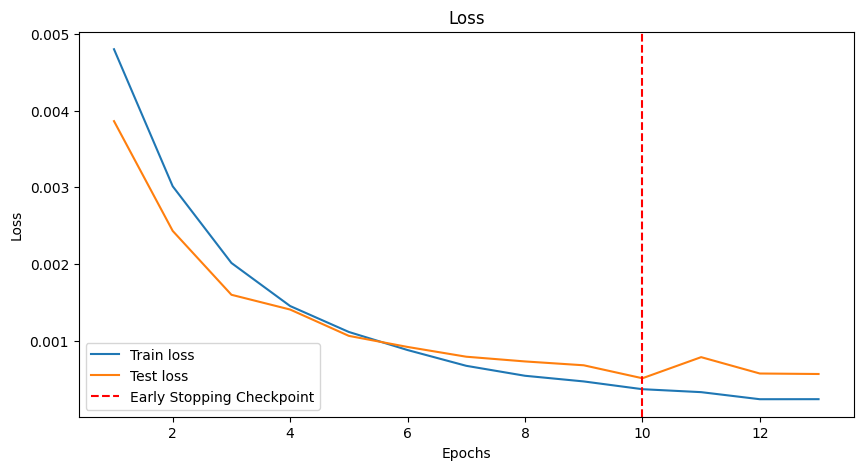

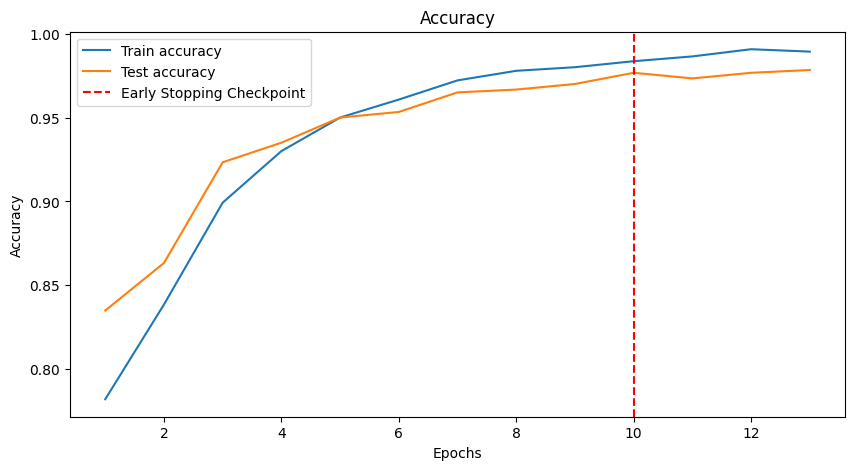

In [26]:
# TODO: Enter your code here

# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Train loss')
plt.plot(range(1,len(te_loss)+1),te_loss, label='Test loss')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1,len(tr_correct)+1), tr_correct, label='Train accuracy')
plt.plot(range(1,len(te_correct)+1), te_correct, label='Test accuracy')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In general, train loss decreases as the number of epochs increases. Test loss reaches the minimum at Epoch 10 and does not improve after epoch 10, causing early stopper to stop the model training after epoch 13. Both train and test accuracy continues to show marginal improvement beyond epoch 10.

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [27]:
# TODO: Enter your code here
from sklearn.model_selection import KFold
from common_utils import MLP, preprocess_dataset

X = df_train_1
Y = y_train_1

print(X.shape, Y.shape)

(1400, 57) (1400,)


> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [28]:
# TODO: Enter your code here
no_folds = 5
cv = KFold(n_splits=no_folds, shuffle=True, random_state=0)

batch_sizes = [32, 64, 128, 256]
X_train_scaled_dict = {}
X_val_scaled_dict = {}
y_train_dict = {}
y_val_dict = {}
accuracy_dict = {}
time_dict = {}

for batch_size in batch_sizes:
    X_train_scaled_dict[batch_size] = []
    X_val_scaled_dict[batch_size] = []
    y_train_dict[batch_size] = []
    y_val_dict[batch_size] = []
    accuracy_dict[batch_size] = []
    time_dict[batch_size] = []

    for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        # Preprocess the dataset
        X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
        
        X_train_scaled_dict[batch_size].append(X_train_scaled)
        X_val_scaled_dict[batch_size].append(X_test_scaled)
        y_train_dict[batch_size].append(y_train)
        y_val_dict[batch_size].append(y_test)

2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [29]:
no_epochs = 100
patience = 3

for batch_size in batch_sizes:
    acc__ = []
    time__ = []
    print(f"Batch size: {batch_size}")
    for i in range(no_folds):
        X_train_scaled = X_train_scaled_dict[batch_size][i]
        X_test_scaled = X_val_scaled_dict[batch_size][i]
        y_train = y_train_dict[batch_size][i]
        y_test = y_val_dict[batch_size][i]

        # Create the datasets and dataloaders
        train_data = AudioDataset(X_train_scaled, y_train)
        test_data = AudioDataset(X_test_scaled, y_test)
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        
        model = MLP(input_dim=57)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.BCELoss()

        early_stopper = EarlyStopper(patience=patience)
        tr_loss, tr_correct = [], []
        te_loss, te_correct = [], []

        for t in range(1,no_epochs+1):
            model.train()
            start = time.perf_counter()
            train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer)
            end = time.perf_counter()

            model.eval()
            test_loss, test_correct = test_loop(test_loader, model, loss_fn)
            
            tr_loss.append(train_loss), tr_correct.append(train_correct)
            te_loss.append(test_loss), te_correct.append(test_correct)

            if early_stopper.early_stop(test_loss): 
                print("Done!")
                break
        
        print(f"Time taken for training last epoch: {end-start:0.4f} seconds")
        
        best_pos = -1 - patience
        print(f"Fold {i+1}: Train_accuracy: {(100*tr_correct[best_pos]):>0.2f}%, Train_loss: {tr_loss[best_pos]:>8f}, Test_accuracy: {(100*te_correct[best_pos]):>0.2f}%, Test_loss: {te_loss[best_pos]:>8f}")

        acc__.append(te_correct[best_pos])
        time__.append(end-start)


    accuracy_dict[batch_size] = acc__
    time_dict[batch_size] = time__
    print()
    

Batch size: 32
Done!
Time taken for training last epoch: 0.0673 seconds
Fold 1: Train_accuracy: 99.46%, Train_loss: 0.000659, Test_accuracy: 98.57%, Test_loss: 0.001091
Done!
Time taken for training last epoch: 0.0689 seconds
Fold 2: Train_accuracy: 98.12%, Train_loss: 0.001335, Test_accuracy: 95.71%, Test_loss: 0.003542
Done!
Time taken for training last epoch: 0.0711 seconds
Fold 3: Train_accuracy: 98.21%, Train_loss: 0.001388, Test_accuracy: 98.93%, Test_loss: 0.001175
Done!
Time taken for training last epoch: 0.0684 seconds
Fold 4: Train_accuracy: 99.73%, Train_loss: 0.000282, Test_accuracy: 98.21%, Test_loss: 0.001705
Done!
Time taken for training last epoch: 0.0548 seconds
Fold 5: Train_accuracy: 98.66%, Train_loss: 0.001149, Test_accuracy: 98.57%, Test_loss: 0.001332

Batch size: 64
Done!
Time taken for training last epoch: 0.0319 seconds
Fold 1: Train_accuracy: 99.73%, Train_loss: 0.000181, Test_accuracy: 98.93%, Test_loss: 0.000386
Done!
Time taken for training last epoch: 0.0

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

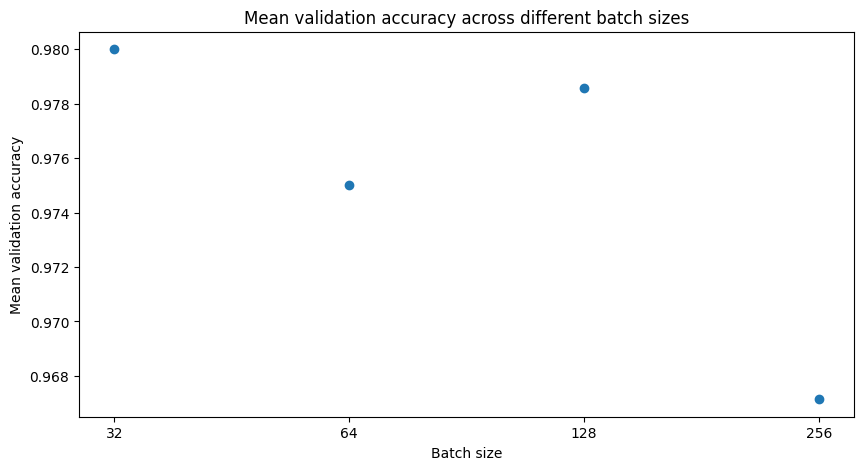

In [30]:
# TODO: Enter your code here

# Plot the mean accuracy for different batch sizes
plt.figure(figsize=(10, 5))
plt.scatter(np.array(batch_sizes).astype('str'), [np.mean(acc) for acc in accuracy_dict.values()])

plt.xlabel('Batch size')
plt.ylabel('Mean validation accuracy')
plt.title('Mean validation accuracy across different batch sizes')
plt.show()





4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

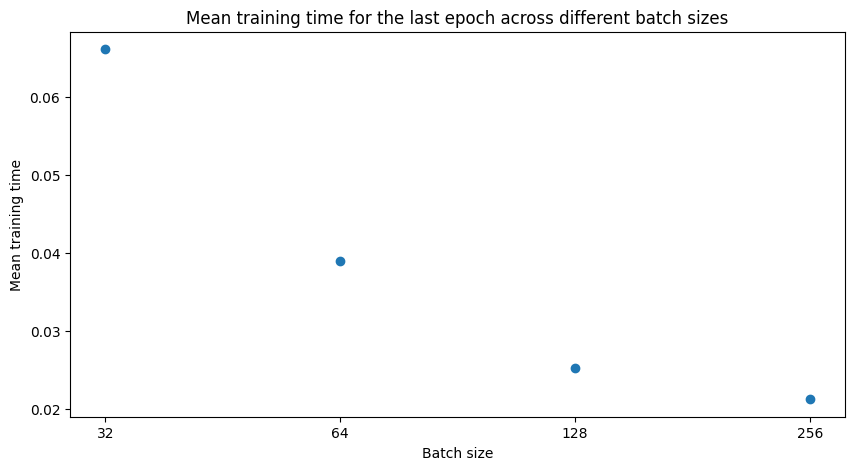

,Batch size,Mean validation accuracy,Mean training time for last epoch
0,32,0.980000,0.066102
1,64,0.975000,0.038976
2,128,0.978571,0.025254
3,256,0.967143,0.021281


In [31]:
# TODO: Enter your code here

# Plot the mean training time for different batch sizes
plt.figure(figsize=(10, 5))
plt.scatter(np.array(batch_sizes).astype('str'), [np.mean(time) for time in time_dict.values()])
plt.xlabel('Batch size')
plt.ylabel('Mean training time')
plt.title('Mean training time for the last epoch across different batch sizes')
plt.show()

# Create a table with the mean accuracy and training time for different batch sizes
df = pd.DataFrame({'Batch size': batch_sizes, 'Mean validation accuracy': [np.mean(acc) for acc in accuracy_dict.values()], 'Mean training time for last epoch': [np.mean(time) for time in time_dict.values()]})
df


5. Select the optimal batch size and state a reason for your selection.

The optimal batch size is 32. Batch size of 32 yields the best mean validation accuracy (98.0%). Even though this also yields the worst mean training time per epoch (approximated by last epeoch timing) across 5 different folds, I believe we can accept this tradeoff given that the total training time will still not be too long since the dataset we are using does not have a lot of examples (only 2k).

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [32]:
# TODO: Enter your code here
from common_utils import MLP

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [33]:
# TODO: Enter your code here
no_epochs = 100
patience = 3
batch_size = 32
hidden_sizes = [64, 128, 256]
accuracy_hidden_size_dict = {}

X_train_scaled = X_train_scaled_dict[batch_size][i]
X_test_scaled = X_val_scaled_dict[batch_size][i]
y_train = y_train_dict[batch_size][i]
y_test = y_val_dict[batch_size][i]

for hidden_size in hidden_sizes:
    acc__ = []
    print(f"Hidden-layer size: {hidden_size}")
    for i in range(no_folds):
        # Create the datasets and dataloaders
        train_data = AudioDataset(X_train_scaled, y_train)
        test_data = AudioDataset(X_test_scaled, y_test)
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        
        model = MLP(input_dim=57, hidden_size_1=hidden_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.BCELoss()
    
        early_stopper = EarlyStopper(patience=patience)
        tr_loss, tr_correct = [], []
        te_loss, te_correct = [], []

        for t in range(1,no_epochs+1):
            model.train()
            train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer)
            
            model.eval()
            test_loss, test_correct = test_loop(test_loader, model, loss_fn)

            te_loss.append(test_loss), te_correct.append(test_correct)
            tr_loss.append(train_loss), tr_correct.append(train_correct)

            if early_stopper.early_stop(test_loss):
                print("Done!")
                break
            
        best_pos = -1 - patience
        print(f"Fold {i+1}: Train_accuracy: {(100*tr_correct[best_pos]):>0.2f}%, Train_loss: {tr_loss[best_pos]:>8f}, Test_accuracy: {(100*te_correct[best_pos]):>0.2f}%, Test_loss: {te_loss[best_pos]:>8f}")

        acc__.append(te_correct[best_pos])
    accuracy_hidden_size_dict[hidden_size] = acc__
    print()
    


Hidden-layer size: 64
Done!
Fold 1: Train_accuracy: 98.39%, Train_loss: 0.001507, Test_accuracy: 97.50%, Test_loss: 0.003053
Done!
Fold 2: Train_accuracy: 99.64%, Train_loss: 0.000321, Test_accuracy: 97.86%, Test_loss: 0.001535
Done!
Fold 3: Train_accuracy: 99.20%, Train_loss: 0.000522, Test_accuracy: 97.86%, Test_loss: 0.002408
Done!
Fold 4: Train_accuracy: 99.20%, Train_loss: 0.000692, Test_accuracy: 98.21%, Test_loss: 0.002675
Done!
Fold 5: Train_accuracy: 98.66%, Train_loss: 0.001095, Test_accuracy: 98.21%, Test_loss: 0.002061

Hidden-layer size: 128
Done!
Fold 1: Train_accuracy: 97.86%, Train_loss: 0.002061, Test_accuracy: 95.71%, Test_loss: 0.002947
Done!
Fold 2: Train_accuracy: 99.64%, Train_loss: 0.000390, Test_accuracy: 98.21%, Test_loss: 0.001945
Done!
Fold 3: Train_accuracy: 99.46%, Train_loss: 0.000554, Test_accuracy: 98.21%, Test_loss: 0.002057
Done!
Fold 4: Train_accuracy: 98.75%, Train_loss: 0.001103, Test_accuracy: 97.86%, Test_loss: 0.002439
Done!
Fold 5: Train_accurac

2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

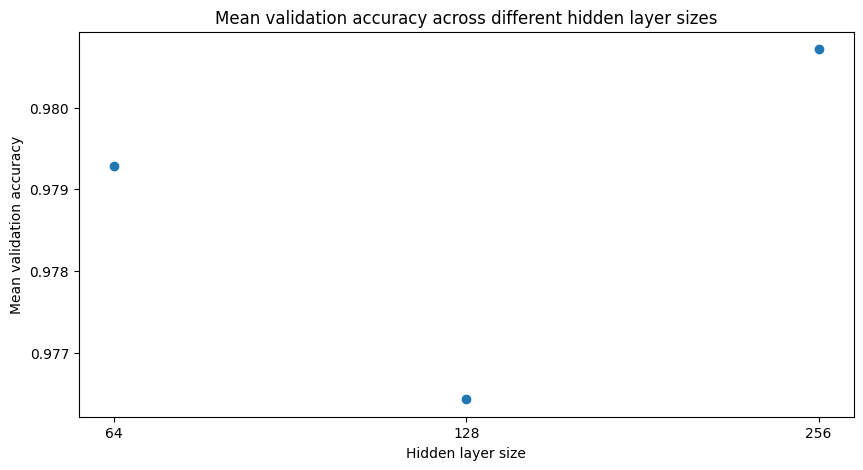

In [34]:
# TODO: Enter your code here
plt.figure(figsize=(10, 5))
plt.scatter(np.array(hidden_sizes).astype('str'), [np.mean(acc) for acc in accuracy_hidden_size_dict.values()])
plt.xlabel('Hidden layer size')
plt.ylabel('Mean validation accuracy')
plt.title('Mean validation accuracy across different hidden layer sizes')
plt.show()  

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [35]:
# TODO: Enter your code here
hidden_size = 256

Hidden-layer size = 256 is the most optimal since it yields the highest mean validation accuracy across all 5 folds.

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

In [36]:
no_epochs = 100
batch_size = 32
hidden_size = 256
early_stopper = EarlyStopper()

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []

# Create the datasets and dataloaders
train_data = AudioDataset(df_train_scaled, y_train_1)
test_data = AudioDataset(df_test_scaled, y_test_1)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

model = MLP(input_dim=57, hidden_size_1=hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

for t in range(no_epochs):
    model.train()
    train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer)

    model.eval()
    test_loss, test_correct = test_loop(test_loader, model, loss_fn)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        torch.save(model.state_dict(), 'best_model.pth')
        break



Epoch 1: Train_accuracy: 86.36%, Train_loss: 0.011973, Test_accuracy: 92.67%, Test_loss: 0.005933
Epoch 2: Train_accuracy: 94.57%, Train_loss: 0.004372, Test_accuracy: 94.33%, Test_loss: 0.003765
Epoch 3: Train_accuracy: 97.50%, Train_loss: 0.002500, Test_accuracy: 95.83%, Test_loss: 0.003509
Epoch 4: Train_accuracy: 98.57%, Train_loss: 0.001641, Test_accuracy: 97.50%, Test_loss: 0.002143
Epoch 5: Train_accuracy: 98.64%, Train_loss: 0.001267, Test_accuracy: 98.17%, Test_loss: 0.001588
Epoch 6: Train_accuracy: 99.43%, Train_loss: 0.000872, Test_accuracy: 98.33%, Test_loss: 0.001575
Epoch 7: Train_accuracy: 99.43%, Train_loss: 0.000568, Test_accuracy: 98.50%, Test_loss: 0.001541
Epoch 8: Train_accuracy: 99.29%, Train_loss: 0.000550, Test_accuracy: 98.67%, Test_loss: 0.001784
Epoch 9: Train_accuracy: 99.71%, Train_loss: 0.000467, Test_accuracy: 98.50%, Test_loss: 0.001910
Epoch 10: Train_accuracy: 99.50%, Train_loss: 0.000552, Test_accuracy: 98.50%, Test_loss: 0.002201
Done!


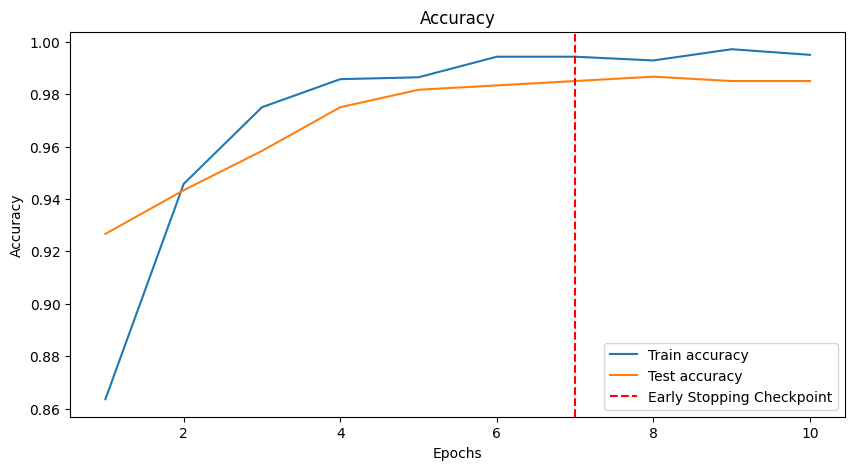

In [37]:
# Plot the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1,len(tr_correct)+1), tr_correct, label='Train accuracy')
plt.plot(range(1,len(te_correct)+1), te_correct, label='Test accuracy')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [38]:
# TODO: Enter your code here
from common_utils import MLP, extract_features


> Install and import shap

In [39]:
# TODO: Enter your code here
!pip install shap
import shap

> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [40]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [41]:
# TODO: Enter your code here
df = extract_features('audio_test.wav')
size_row = df.shape[0]
size_column = df.shape[1]

df

,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,audio_test.wav,0.431877,0.080057,0.056604,0.000293,1191.619716,40957.603068,1726.917471,38831.324373,2794.225223,...,-3.746181,56.647854,-6.391425,37.167591,-2.303412,43.675926,-8.247708,30.502138,-13.78649,46.94154


> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [42]:
# TODO: Enter your code here
df_test_4 = df.drop(columns=['filename'])

# We will fit the StandardScaler on the training partition data and transform the converted audio data using the same scaler
standard_scaler = preprocessing.StandardScaler()
_ = standard_scaler.fit_transform(df_train_1)
df_test_scaled_4 = standard_scaler.transform(df_test_4)

print(df_test_scaled_4.shape)

df_test_scaled_4



(1, 57)


array([[ 0.22868671, -0.08483411, -1.43181575, -0.77946489, -1.50543707,
        -0.91264693, -1.09286234, -0.59377613, -1.28037995, -0.63326531,
        -1.43609628, -1.01375111,  0.50490395, -0.9908257 ,  0.92948526,
        -0.99543556, -1.05019862, -1.57451881, -0.2564259 ,  1.57449242,
        -0.7074898 ,  0.76052143, -0.76986086,  0.18193013, -0.568974  ,
        -0.0664284 , -0.55043284,  0.33739732, -0.32715521,  1.43604614,
        -0.7598396 , -0.53518743, -0.49639944,  0.52167612, -0.61796026,
        -0.40965031, -0.84873116,  0.85581375,  0.04123958, -0.75576541,
         0.33413841, -1.30927957, -0.77261838, -1.07932773, -0.53170059,
        -0.60481567, -0.64131892, -1.11283167,  0.45744627,  0.35831617,
        -0.2646091 , -0.66243104, -0.06210785, -0.75528419, -0.50097638,
        -2.33145158,  0.03010326]])

2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [44]:
# TODO: Enter your code here
audio_test_data = torch.tensor(df_test_scaled_4, dtype=torch.float)
model = MLP(input_dim=57, hidden_size_1=256)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    pred = model(audio_test_data)
    pred_label = int((pred > 0.5).item())
print(pred_label)


0


C:\Users\huang\AppData\Local\Temp\ipykernel_3092\2708679133.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


The predicted label '0' is mapped to blues. Hence, the sample audio is predicted to be from blues.

> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using training dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

(1, 57, 1)


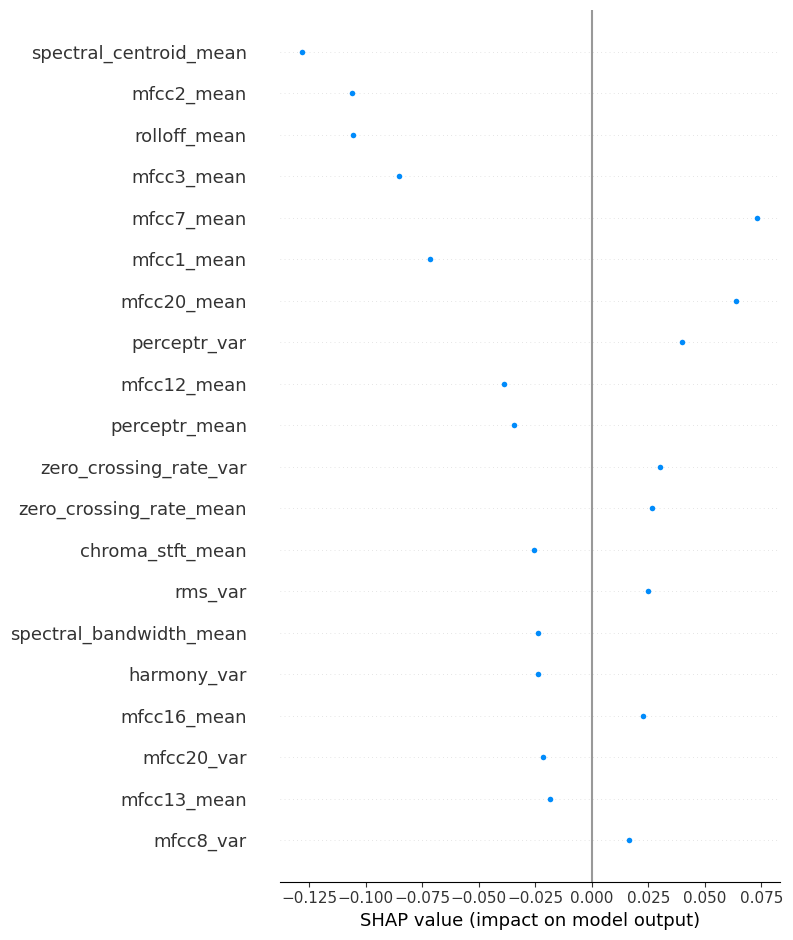

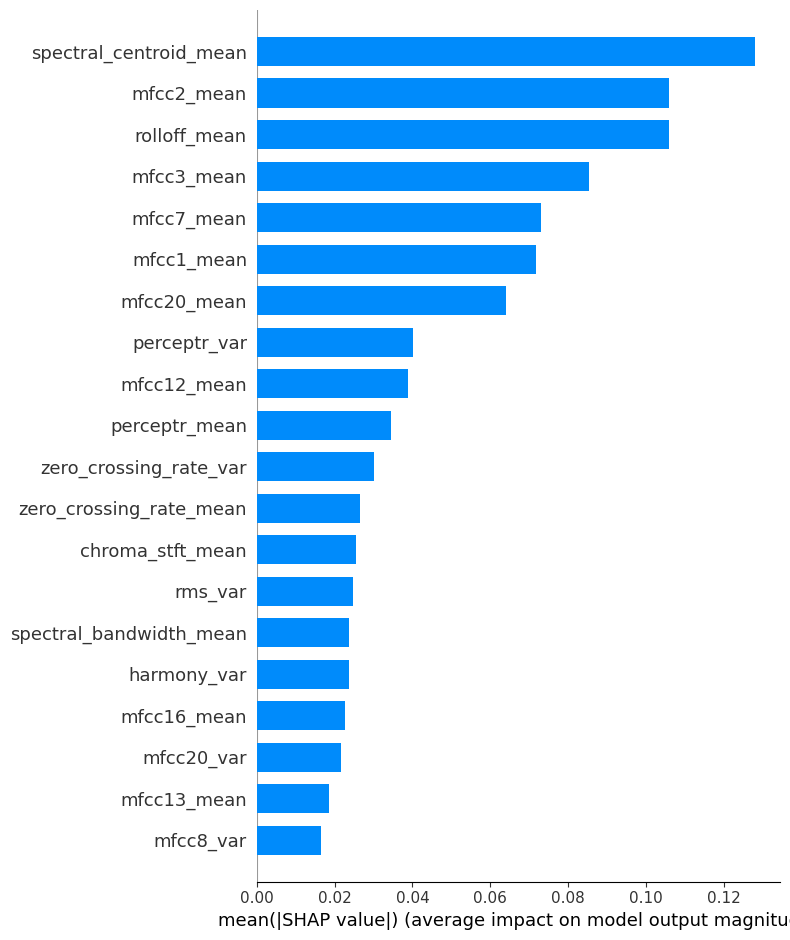

In [45]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# TODO: Enter your code here
X_train = torch.tensor(df_train_scaled, dtype=torch.float)

# Create SHAP explainer
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(audio_test_data)


print(shap_values.shape)
# Plot feature importance
shap.summary_plot(shap_values[:,:,0], feature_names = df_test_4.columns)
shap.summary_plot(shap_values[:,:,0], feature_names = df_test_4.columns, plot_type='bar')


In [46]:
shap.initjs()

shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], feature_names = df_test_4.columns)

Model output = expected base value + sum of all SHAP values where the expected base value = average model prediction across all fitted data points

When the model takes in the preprocessed audio test sample as input, spectral_centroid_mean, mfcc2_mean, rolloff_mean and mfcc3_mean are locally important features that drives the sigmoid activation value to be closer to 0. Furthermore, while there were other locally important factors like mfcc7_mean and mfcc20_mean that are pushing the model prediction towards more positive, these factors are relatively weaker in magnitude compared to the aforementioned downward-driving factors. As a result, this influences the model to make a prediction of "0".